最適解取得

a set of optimal solutions
number of poplation is 100
number of generation is 400
number of variable is 30
HV 1.1004251273098296
execute time is 14.460670948028564 sec


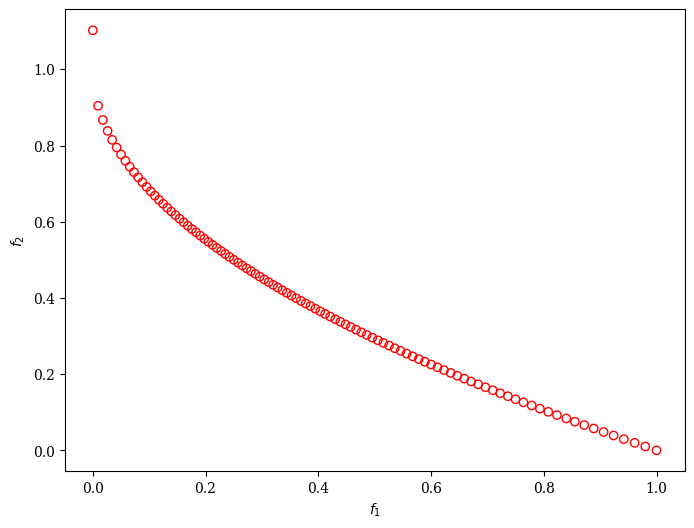

In [ ]:
import random
import numpy as np
import openpyxl
import pandas as pd
import string
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.decomposition.tchebicheff import Tchebicheff
from pymoo.decomposition.pbi import PBI
from pymoo.decomposition.weighted_sum import WeightedSum
from pymoo.problems import get_problem
import pymoo.gradient.toolbox as anp
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import HV
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.individual import Individual
from pymoo.core.problem import Problem
from pymoo.util.remote import Remote
from pymoo.indicators.igd import IGD
from pymoo.util.ref_dirs import get_reference_directions
import time
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM


def fix_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
####################################################

#ZDT

class MyZDT(Problem):

    def __init__(self, n_var, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=0, xu=1, vtype=float, **kwargs)

class MyZDT1(MyZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])
        
class MyZDT2(MyZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power((f1 * 1.0 / g), 2))

        out["F"] = anp.column_stack([f1, f2])
        
class MyZDT3(MyZDT):
    def _calc_pareto_front(self, n_points=100, flatten=True):
        regions = [[0, 0.0830015349],
                   [0.182228780, 0.2577623634],
                   [0.4093136748, 0.4538821041],
                   [0.6183967944, 0.6525117038],
                   [0.8233317983, 0.8518328654]]

        pf = []

        for r in regions:
            x1 = np.linspace(r[0], r[1], int(n_points / len(regions)))
            x2 = 1 - np.sqrt(x1) - x1 * np.sin(10 * np.pi * x1)
            pf.append(np.array([x1, x2]).T)

        if not flatten:
            pf = np.concatenate([pf[None,...] for pf in pf])
        else:
            pf = np.row_stack(pf)

        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power(f1 * 1.0 / g, 0.5) - (f1 * 1.0 / g) * anp.sin(10 * anp.pi * f1))

        out["F"] = anp.column_stack([f1, f2])
        
class MyZDT4(MyZDT):
    def __init__(self, n_var):
        super().__init__(n_var=n_var)
        self.xl = -5 * np.ones(self.n_var)
        self.xl[0] = 0.0
        self.xu = 5 * np.ones(self.n_var)
        self.xu[0] = 1.0
        self.func = self._evaluate

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0
        g += 10 * (self.n_var - 1)
        for i in range(1, self.n_var):
            g += x[:, i] * x[:, i] - 10.0 * anp.cos(4.0 * anp.pi * x[:, i])
        h = 1.0 - anp.sqrt(f1 / g)
        f2 = g * h

        out["F"] = anp.column_stack([f1, f2])

class MyZDT6(MyZDT):

    def __init__(self, n_var, **kwargs):
        super().__init__(n_var=n_var, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0.2807753191, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 1 - anp.exp(-4 * x[:, 0]) * anp.power(anp.sin(6 * anp.pi * x[:, 0]), 6)
        g = 1 + 9.0 * anp.power(anp.sum(x[:, 1:], axis=1) / (self.n_var - 1.0), 0.25)
        f2 = g * (1 - anp.power(f1 / g, 2))

        out["F"] = anp.column_stack([f1, f2])
        

####################################################

#Kursawe


class rev_Kursawe(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, xl=-5, xu=5, vtype=float)

    def _evaluate(self, x, out, *args, **kwargs):
        l = []
        for i in range(2):
            l.append(-10 * anp.exp(-0.2 * anp.sqrt(anp.square(x[:, i]) + anp.square(x[:, i + 1]))))
        f1 = anp.sum(anp.column_stack(l), axis=1)

        f2 = anp.sum(anp.power(anp.abs(x), 0.8) + 5 * anp.sin(anp.power(x, 3)), axis=1)

        f=f1
        f1=f2
        f2=f

        out["F"] = anp.column_stack([f1, f2])

    def _calc_pareto_front(self, *args, **kwargs):
        return Remote.get_instance().load("pymoo", "pf", "kursawe.pf")
       
####################################################

#CTP


def g_linear(x):
    return 1 + np.sum(x, axis=1)


def g_multimodal(x):
    A = 10
    return 1 + A * x.shape[1] + np.sum(x ** 2 - A * np.cos(2 * np.pi * x), axis=1)


class MyCTP(Problem):

    def __init__(self, n_var, n_ieq_constr=1, option="linear"):
        super().__init__(n_var=n_var, n_obj=2, n_ieq_constr=n_ieq_constr, xl=0, xu=1, vtype=float)

        if option == "linear":
            self.calc_g = g_linear

        elif option == "multimodal":
            self.calc_g = g_multimodal
            self.xl[1:] = -5.12
            self.xu[1:] = 5.12

        else:
            print("Unknown option for CTP single.")

    def calc_objectives(self, x):
        f1 = x[:, 0]
        gg = self.calc_g(x[:, 1:])
        f2 = gg * (1 - (f1 / gg) ** 0.5)
        return f1, f2

    def calc_constraint(self, theta, a, b, c, d, e, f1, f2):

        # Equations in readable format
        exp1 = (f2 - e) * anp.cos(theta) - f1 * anp.sin(theta)

        exp2 = (f2 - e) * anp.sin(theta) + f1 * anp.cos(theta)
        exp2 = b * anp.pi * (exp2 ** c)
        exp2 = anp.abs(anp.sin(exp2))
        exp2 = a * (exp2 ** d)

        # as in the paper
        # val = - (exp1 - exp2)

        # as in the C code of NSGA2
        val = 1 - exp1 / exp2

        # ONE EQUATION
        # _val = - (anp.cos(theta) * (f2 - e) - anp.sin(theta) * f1 -
        #           a * anp.abs(anp.sin(b * anp.pi * (anp.sin(theta) * (f2 - e) + anp.cos(theta) * f1) ** c)) ** d)

        return val

    def _calc_pareto_front(self, *args, **kwargs):
        return Remote.get_instance().load("pymoo", "pf", "CTP", str(self.__class__.__name__).lower() + ".pf")

class MyCTP5(MyCTP):

    def _evaluate(self, x, out, *args, **kwargs):
        f1, f2 = self.calc_objectives(x)
        out["F"] = anp.column_stack([f1, f2])

        theta = -0.2 * anp.pi
        a, b, c, d, e = 0.1, 10, 2, 0.5, 1

        out["G"] = self.calc_constraint(theta, a, b, c, d, e, f1, f2)
    
####################################################

def Mysort(res, pop_size):
    sorted_a={} #keyをi番目の個体、valueを目的関数とした辞書

    #個体情報をコピー
    for i in range(pop_size):
        sorted_a[i] = res.pop[i].get("F")
    

    #f1に関して昇順でソート(左から順番)
    sorted_b = sorted(sorted_a.items(), reverse=False, key=lambda x:x[1][0])
    
    return sorted_b

####################################################

def print_used_solutions(plot, res, iter_list):
    for i in iter_list:
        plot.add(res.pop[i].F, marker='*', facecolor="none", edgecolor="blue", s=100, label="used solutions")

####################################################

def eval_hv(F):
    ref = np.array([1.2, 1.2])
    ind = HV(ref_point=ref)
    return ind(F)

####################################################

def print_mylist(l): #中央の個体を赤で表示
    for i in range(len(l)):
        if i == len(l)//2 - 1:
            s = str(l[i])
            print('\033[31m'+s+'\033[0m')
        else:
            print(l[i])

####################################################

#メインプログラム 
n_var = 30 #変数の個数

problem=MyZDT1(n_var=n_var)
#problem=MyZDT2(n_var=n_var)
#problem=MyZDT3(n_var=n_var)
#problem=MyZDT4(n_var=n_var)
#problem=MyCTP5(n_var=n_var)
#problem=rev_Kursawe()
        
pop_size = 100 #個体数

n_gen = 400 #世代数

fix_seed(seed=1)
sampling1 = FloatRandomSampling().do(problem, pop_size)#初期ランダム解生成

ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#2目的
#ref_dirs = get_reference_directions("energy", 2, 200, seed=1)#2目的
#ref_dirs = get_reference_directions("uniform", 3, n_partitions=)#3目的

algorithm = MOEAD(ref_dirs,
                 decomposition=Tchebicheff(),
                 n_neighbor=20,
                 prob_neighbor_mating=1,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling1)

res1 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               seed=1)

mylist=Mysort(res1, algorithm.pop_size)

#print_mylist(mylist) #個体番号と目的関数の辞書

#1番0に近いF1値のインデックスとキーを表示
F1_values = [row[1] for row in res1.F]
closest_index = min(range(len(F1_values)), key=lambda i: abs(F1_values[i]))
#print(f"0に一番近い値：{closest_index}")
#print(F1_values[closest_index])

iter_list=[0] #セットしたい最適解の個体番号

#for i in range(pop_size):
    #iter_list.append(i)


####################################################


#pf = get_problem("ctp5").pareto_front()
pf = problem.pareto_front()

print("a set of optimal solutions")
print(f"number of poplation is {pop_size}")
print(f"number of generation is {n_gen}")
print(f"number of variable is {n_var}")
print("HV", eval_hv(res1.F))
print(f"execute time is {res1.exec_time} sec")

plot = Scatter()

#plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.add(res1.F, facecolor="none", edgecolor="red")
#print_used_solutions(plot, res1, iter_list)


#軸範囲の設定
plot.do()
ax = plot.get_plot()
#print(ax)
#ax.set_ylim(-0.1,1.1)
#ax.set_ylim(-0.1,2.0) #ZDT4
#ax.set_ylim(-1.1,1.1) #ZDT3
#ax.set_xlim(-0.1,1.1)


plot.show()

In [ ]:
#print_mylist(mylist)    #解の値を表示

(99, array([2.48104770e-06, 1.10216607e+00]))
(98, array([0.00923118, 0.90418474]))
(97, array([0.01771101, 0.86698869]))
(96, array([0.02617043, 0.83830837]))
(95, array([0.03428057, 0.81490166]))
(94, array([0.04220863, 0.79459718]))
(93, array([0.05003134, 0.77640793]))
(92, array([0.05773168, 0.7597797 ]))
(91, array([0.06539585, 0.74432363]))
(90, array([0.07290165, 0.7300338 ]))
(89, array([0.08037418, 0.71653865]))
(88, array([0.08783529, 0.70367525]))
(87, array([0.0952892 , 0.69135368]))
(86, array([0.10263751, 0.67967553]))
(85, array([0.10998451, 0.66840303]))
(84, array([0.11731542, 0.65752567]))
(83, array([0.12464612, 0.64698408]))
(82, array([0.13190996, 0.63684104]))
(81, array([0.13922098, 0.62691581]))
(80, array([0.14649065, 0.61728864]))
(79, array([0.15380683, 0.60788142]))
(78, array([0.16101495, 0.5987652 ]))
(77, array([0.16835233, 0.58972327]))
(76, array([0.17570119, 0.5809002 ]))
(75, array([0.18296551, 0.57229125]))
(74, array([0.19034209, 0.56376931]))
(73,

ベンチマーク関数のパラメータ変更

In [ ]:
####################################################

#ここでパラメータを変更する

class MyZDT(Problem):

    def __init__(self, n_var, **kwargs):#変数の個数を設定
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=0, xu=1, vtype=float, **kwargs)
        
####################################################

class MyZDT1(MyZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        g -= 0.1
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])

####################################################
        
class MyZDT2(MyZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        g -= 0.05
        f2 = g * (1 - anp.power((f1 * 1.0 / g), 2))

        out["F"] = anp.column_stack([f1, f2])

        
####################################################
        
class MyZDT3(MyZDT):
    
    def _calc_pareto_front(self, n_points=100, flatten=True):
        regions = [[0, 0.0830015349],
                   [0.182228780, 0.2577623634],
                   [0.4093136748, 0.4538821041],
                   [0.6183967944, 0.6525117038],
                   [0.8233317983, 0.8518328654]]

        pf = []

        for r in regions:
            x1 = np.linspace(r[0], r[1], int(n_points / len(regions)))
            x2 = 1 - np.sqrt(x1) - x1 * np.sin(10 * np.pi * x1)
            pf.append(np.array([x1, x2]).T)

        if not flatten:
            pf = np.concatenate([pf[None,...] for pf in pf])
        else:
            pf = np.row_stack(pf)

        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        g -= 0.1
        f2 = g * (1 - anp.power(f1 * 1.0 / g, 0.5) - (f1 * 1.0 / g) * anp.sin(10 * anp.pi * f1))

        out["F"] = anp.column_stack([f1, f2])

        
####################################################
        
class MyZDT4(MyZDT):
    
    def __init__(self, n_var):
        super().__init__(n_var=n_var)
        self.xl = -5 * np.ones(self.n_var)
        self.xl[0] = 0.0
        self.xu = 5 * np.ones(self.n_var)
        self.xu[0] = 1.0
        self.func = self._evaluate

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0
        g += 10 * (self.n_var - 1)
        for i in range(1, self.n_var):
            g += x[:, i] * x[:, i] - 10.0 * anp.cos(4.0 * anp.pi * x[:, i])
        g -= 0.1
        h = 1.0 - anp.sqrt(f1 / g)
        f2 = g * h

        out["F"] = anp.column_stack([f1, f2])

        
####################################################

class MyZDT6(MyZDT):

    def __init__(self, n_var, **kwargs):
        super().__init__(n_var=n_var, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0.2807753191, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 1 - anp.exp(-4 * x[:, 0]) * anp.power(anp.sin(6 * anp.pi * x[:, 0]), 6)
        g = 1 + 9.0 * anp.power(anp.sum(x[:, 1:], axis=1) / (self.n_var - 1.0), 0.25)
        g -= 0.1
        f2 = g * (1 - anp.power(f1 / g, 2))

        out["F"] = anp.column_stack([f1, f2])
        

####################################################

In [ ]:
#パラメータ設定
problem=MyZDT1(n_var=n_var)        #問題
pop_size = 50                      #個体数
n_gen = 400                        #世代数
res_sample = 81                    #試行回数
div_gen = 10                       #何世代毎に分けてhvを取得
dec = Tchebicheff()                #スカラー化関数
neighbor = 25                       #近傍のサイズ
prob = 1                           #近傍での交叉確立
Algorithm = 1                      #1:MOEAD, 2:NSGA2

比較用(提案手法)

number of res_sample is 81
number of poplation is 50
number of generation is 400
number of variable is 30
random execute time is 11.792192220687866 sec
my execute time is 11.89839243888855 sec


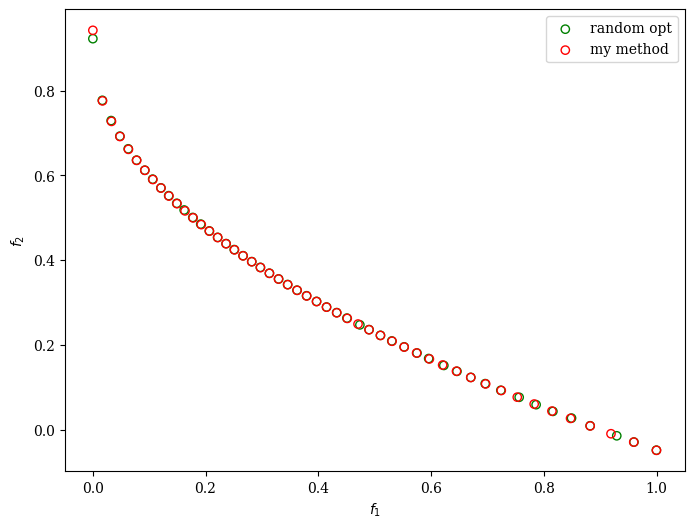

In [ ]:
####################################################


def Myset(sampling, iter_list, res):
    for i in range(len(iter_list)):
        sampling[49].set("X", res.pop[iter_list[i]].get("X"))  #同じインデックスを入れ替える


####################################################

#メインプログラム 左端の非劣解を入れ替え

iter_list=[98] #セットしたい最適解の個体番号

hv_list1={} #keyをi番目のseed、valueをhvとした辞書
hv_list2={}

hv_history1=[0] * (1 + n_gen//div_gen) #世代毎のhv
hv_history2=[0] * (1 + n_gen//div_gen)

ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#2目的
#ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#3目的

#実験本体

for i in range(res_sample): #ランダム初期解

    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling2 = FloatRandomSampling().do(problem, pop_size)

    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2)   

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2
    

    res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res2.history)): #10世代毎の、hvの累和
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history1[x] += eval_hv(res2.history[k].pop.get("F"))
            x += 1
    
    hv_list1[i]=eval_hv(res2.F)

for i in range(len(hv_history1)):
    hv_history1[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list3 = sorted(hv_list1.items(), reverse=False, key=lambda x:x[1])

ave1=0
for i in hv_list3:
    ave1+=i[1]

ave2=ave1/res_sample


for i in range(res_sample): #提案手法
    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling3 = FloatRandomSampling().do(problem, pop_size)

    Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2

    res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res3.history)):
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history2[x] += eval_hv(res3.history[k].pop.get("F"))
            x += 1
    
    hv_list2[i]=eval_hv(res3.F)

for i in range(len(hv_history2)):
    hv_history2[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list4 = sorted(hv_list2.items(), reverse=False, key=lambda x:x[1])

ave3=0
for i in hv_list4:
    ave3+=i[1]

ave4=ave3/res_sample


p_name = f"{problem.__class__.__name__}"

alg_name = f"{algorithm.__class__.__name__}"

writer = pd.ExcelWriter(f'{p_name}_{alg_name}_p{pop_size}_divided{div_gen}-L.xlsx')

hv_dict = {}

gen_list = []

for i in range(1 + n_gen//div_gen):
    gen_list.append(i * div_gen)


hv_dict.update({"gen" : gen_list})
hv_dict.update({"random" : hv_history1})
hv_dict.update({"MOEA/D-L" : hv_history2})

df = pd.DataFrame(hv_dict)
df.to_excel(writer, sheet_name="shift_0", index=False, header=True)
writer.close()



seed=hv_list4[res_sample//2][0]

seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling2 = FloatRandomSampling().do(problem, pop_size)


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)


seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling3 = FloatRandomSampling().do(problem, pop_size)

Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

####################################################


pf = problem.pareto_front()

print(f"number of res_sample is {res_sample}")
print(f"number of poplation is {pop_size}")
print(f"number of generation is {n_gen}")
print(f"number of variable is {n_var}")
#print("random HV", hv(res2.F))
#print("my HV", hv(res3.F))
print(f"random execute time is {res2.exec_time} sec")
print(f"my execute time is {res3.exec_time} sec")

plot = Scatter(legend=True)
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7, label="original pf")
plot.add(res2.F, facecolor="none", edgecolor="green", label="random opt")
plot.add(res3.F, facecolor="none", edgecolor="red", label="my method")
print_used_solutions(plot, res1, iter_list)


#軸範囲の設定
plot.do()
ax = plot.get_plot()
#ax.set_ylim(-0.1,1.1)
#ax.set_ylim(-0.1,2.0) #ZDT4
#ax.set_ylim(-1.1,1.1) #ZDT3
#ax.set_xlim(-0.1,1.1)


plot.show()



#ランダム解のdiv_gen世代ごとのプロット
import matplotlib.pyplot as plt

R2 = res2
R3 = res3


for i in range(int(n_gen/div_gen)):

    r2 = R2.history[i*div_gen].pop.get("F")
    r3 = R3.history[i*div_gen].pop.get("F")

    plot = Scatter(legend=True)

    plot.add(r2, facecolor="none", edgecolor="green", label="random opt")
    plot.add(r3, facecolor="none", edgecolor="red", label="my method")

    plot.show()

    plt.savefig(f"{p_name}_p{pop_size}_L_gen{i*div_gen}.png")


number of res_sample is 81
number of poplation is 50
number of generation is 400
number of variable is 30
random execute time is 11.528924226760864 sec
my execute time is 11.920869827270508 sec


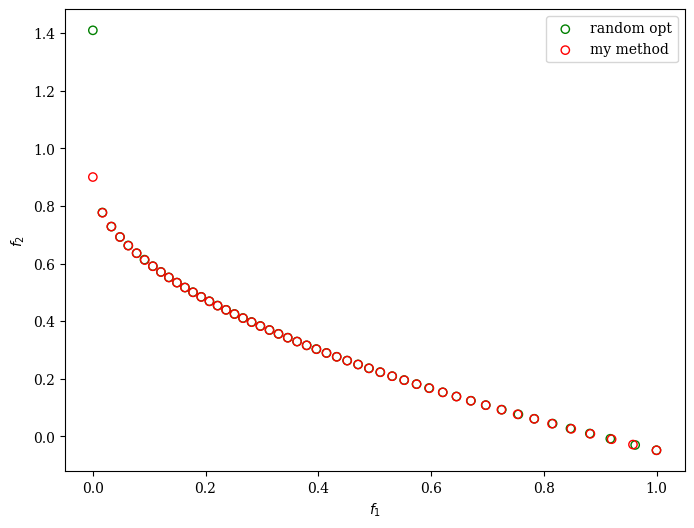

In [ ]:
####################################################


def Myset(sampling, iter_list, res):
    for i in range(len(iter_list)):
        sampling[24].set("X", res.pop[iter_list[i]].get("X"))  #同じインデックスを入れ替える


####################################################

#メインプログラム 中央の非劣解を入れ替え

iter_list=[49] #セットしたい最適解の個体番号 ZDT3だけ64


hv_list1={} #keyをi番目のseed、valueをhvとした辞書
hv_list2={}

hv_history1=[0] * (1 + n_gen//div_gen) #世代毎のhv
hv_history2=[0] * (1 + n_gen//div_gen)

ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#2目的
#ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#3目的

#実験本体

for i in range(res_sample): #ランダム初期解

    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling2 = FloatRandomSampling().do(problem, pop_size)

    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2) 

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2
   

    res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res2.history)): #10世代毎の、hvの累和
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history1[x] += eval_hv(res2.history[k].pop.get("F"))
            x += 1
    
    hv_list1[i]=eval_hv(res2.F)

for i in range(len(hv_history1)):
    hv_history1[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list3 = sorted(hv_list1.items(), reverse=False, key=lambda x:x[1])

ave1=0
for i in hv_list3:
    ave1+=i[1]

ave2=ave1/res_sample


for i in range(res_sample): #提案手法
    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling3 = FloatRandomSampling().do(problem, pop_size)

    Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2

    res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res3.history)):
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history2[x] += eval_hv(res3.history[k].pop.get("F"))
            x += 1
    
    hv_list2[i]=eval_hv(res3.F)

for i in range(len(hv_history2)):
    hv_history2[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list4 = sorted(hv_list2.items(), reverse=False, key=lambda x:x[1])

ave3=0
for i in hv_list4:
    ave3+=i[1]

ave4=ave3/res_sample


p_name = f"{problem.__class__.__name__}"

alg_name = f"{algorithm.__class__.__name__}"

writer = pd.ExcelWriter(f'{p_name}_{alg_name}_p{pop_size}_divided{div_gen}-M.xlsx')

hv_dict = {}

gen_list = []

for i in range(1 + n_gen//div_gen):
    gen_list.append(i * div_gen)


hv_dict.update({"gen" : gen_list})
hv_dict.update({"random" : hv_history1})
hv_dict.update({"MOEA/D-M" : hv_history2})

df = pd.DataFrame(hv_dict)
df.to_excel(writer, sheet_name="shift_0", index=False, header=True)
writer.close()



seed=hv_list4[res_sample//2][0]

seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling2 = FloatRandomSampling().do(problem, pop_size)


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling3 = FloatRandomSampling().do(problem, pop_size)

Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

####################################################


pf = problem.pareto_front()

print(f"number of res_sample is {res_sample}")
print(f"number of poplation is {pop_size}")
print(f"number of generation is {n_gen}")
print(f"number of variable is {n_var}")
#print("random HV", hv(res2.F))
#print("my HV", hv(res3.F))
print(f"random execute time is {res2.exec_time} sec")
print(f"my execute time is {res3.exec_time} sec")

plot = Scatter(legend=True)
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7, label="original pf")
plot.add(res2.F, facecolor="none", edgecolor="green", label="random opt")
plot.add(res3.F, facecolor="none", edgecolor="red", label="my method")
print_used_solutions(plot, res1, iter_list)


#軸範囲の設定
plot.do()
ax = plot.get_plot()
#print(ax)
#ax.set_ylim(-0.1,1.1)
#ax.set_ylim(-0.1,2.0) #ZDT4
#ax.set_ylim(-1.1,1.1) #ZDT3
#ax.set_xlim(-0.1,1.1)


plot.show()



#ランダム解のdiv_gen世代ごとのプロット
import matplotlib.pyplot as plt

R2 = res2
R3 = res3


for i in range(int(n_gen/div_gen)):

    r2 = R2.history[i*div_gen].pop.get("F")
    r3 = R3.history[i*div_gen].pop.get("F")

    plot = Scatter(legend=True)

    plot.add(r2, facecolor="none", edgecolor="green", label="random opt")
    plot.add(r3, facecolor="none", edgecolor="red", label="my method")

    plot.show()
    
    plt.savefig(f"{p_name}_p{pop_size}_M_gen{i*div_gen}.png")


number of res_sample is 81
number of poplation is 50
number of generation is 400
number of variable is 30
random execute time is 8.862536668777466 sec
my execute time is 8.522348165512085 sec


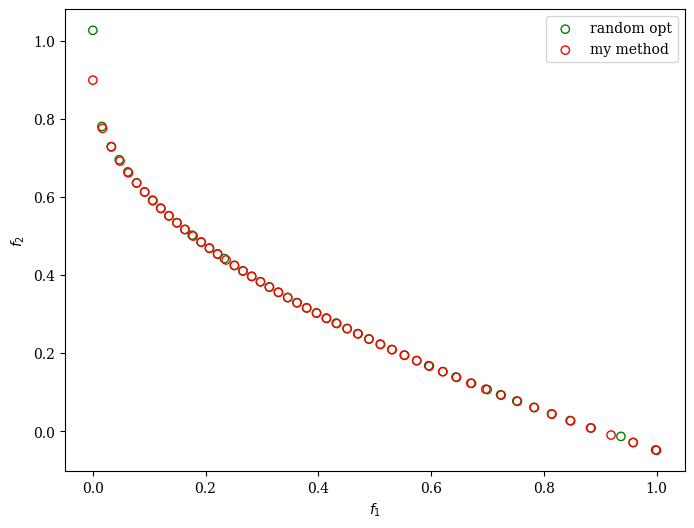

In [ ]:
####################################################


def Myset(sampling, iter_list, res):
    for i in range(len(iter_list)):
        sampling[0].set("X", res.pop[iter_list[i]].get("X"))  #同じインデックスを入れ替える 入れ替え先の初期解
        

####################################################

#メインプログラム 右端の非劣解を入れ替え

iter_list=[0] #セットしたい最適解の個体番号

hv_list1={} #keyをi番目のseed、valueをhvとした辞書
hv_list2={}

hv_history1=[0] * (1 + n_gen//div_gen) #世代毎のhv
hv_history2=[0] * (1 + n_gen//div_gen)

ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#2目的
#ref_dirs = get_reference_directions("uniform", 2, n_partitions=pop_size-1)#3目的

#実験本体

for i in range(res_sample): #ランダム初期解

    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling2 = FloatRandomSampling().do(problem, pop_size)

    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

 
    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2)   

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2
   

    res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res2.history)): #10世代毎の、hvの累和
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history1[x] += eval_hv(res2.history[k].pop.get("F"))
            x += 1
    
    hv_list1[i]=eval_hv(res2.F)

for i in range(len(hv_history1)):
    hv_history1[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list3 = sorted(hv_list1.items(), reverse=False, key=lambda x:x[1])

ave1=0
for i in hv_list3:
    ave1+=i[1]

ave2=ave1/res_sample


for i in range(res_sample): #提案手法
    seed_value = int(time.time())
    fix_seed(seed=seed_value)
    sampling3 = FloatRandomSampling().do(problem, pop_size)

    Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


    algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

    algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

    if Algorithm == 1:
        algorithm = algorithm1
    else:
        algorithm = algorithm2
    
    res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

    x = 0
    for k in range(len(res3.history)):
        if (k + 1) % div_gen == 0 or k == 0:
            hv_history2[x] += eval_hv(res3.history[k].pop.get("F"))
            x += 1
    
    hv_list2[i]=eval_hv(res3.F)

for i in range(len(hv_history2)):
    hv_history2[i] /= res_sample #世代毎のhvの平均
    
#hvに関して昇順でソート(左から順番)
hv_list4 = sorted(hv_list2.items(), reverse=False, key=lambda x:x[1])

ave3=0
for i in hv_list4:
    ave3+=i[1]

ave4=ave3/res_sample


p_name = f"{problem.__class__.__name__}"

alg_name = f"{algorithm.__class__.__name__}"

writer = pd.ExcelWriter(f'{p_name}_{alg_name}_p{pop_size}_divided{div_gen}-R.xlsx')

hv_dict = {}

gen_list = []

for i in range(1 + n_gen//div_gen):
    gen_list.append(i * div_gen)


hv_dict.update({"gen" : gen_list})
hv_dict.update({"random" : hv_history1})
hv_dict.update({"MOEA/D-R" : hv_history2})

df = pd.DataFrame(hv_dict)
df.to_excel(writer, sheet_name="shift_0", index=False, header=True)
writer.close()



seed=hv_list4[res_sample//2][0]

seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling2 = FloatRandomSampling().do(problem, pop_size)


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling2)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling2)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res2 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)




seed_value = int(time.time())
fix_seed(seed=seed_value)
sampling3 = FloatRandomSampling().do(problem, pop_size)

Myset(sampling3, iter_list, res1) #最適解res1の設計変数をセット


algorithm1 = MOEAD(ref_dirs,
                 decomposition=dec,
                 n_neighbors=neighbor,
                 prob_neighbor_mating=prob,
                 crossover=SBX(eta=20, prob=1),  
                 mutation=PM(prob_var=1/n_var),
                 sampling=sampling3)

algorithm2 = NSGA2(pop_size=pop_size,
                  crossover=SBX(eta=20, prob=1),  
                  mutation=PM(prob_var=1/n_var),
                  sampling=sampling3)

if Algorithm == 1:
    algorithm = algorithm1
else:
    algorithm = algorithm2

res3 = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               save_history=True,
               seed=None)

####################################################


pf = problem.pareto_front()

print(f"number of res_sample is {res_sample}")
print(f"number of poplation is {pop_size}")
print(f"number of generation is {n_gen}")
print(f"number of variable is {n_var}")
#print("random HV", hv(res2.F))
#print("my HV", hv(res3.F))
print(f"random execute time is {res2.exec_time} sec")
print(f"my execute time is {res3.exec_time} sec")

plot = Scatter(legend=True)
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7, label="original pf")
plot.add(res2.F, facecolor="none", edgecolor="green", label="random opt")
plot.add(res3.F, facecolor="none", edgecolor="red", label="my method")
print_used_solutions(plot, res1, iter_list)


#軸範囲の設定
plot.do()
ax = plot.get_plot()
#print(ax)
#ax.set_ylim(-0.1,1.1)
#ax.set_ylim(-0.1,2.0) #ZDT4
#ax.set_ylim(-1.1,1.1) #ZDT3
#ax.set_xlim(-0.1,1.1)

plot.show()


#ランダム解のdiv_gen世代ごとのプロット
import matplotlib.pyplot as plt

R2 = res2
R3 = res3

#print(R2.history[1].pop.get("F"))

for i in range(int(n_gen/div_gen)):

    r2 = R2.history[i*div_gen].pop.get("F")
    r3 = R3.history[i*div_gen].pop.get("F")

    plot = Scatter(legend=True)

    plot.add(r2, facecolor="none", edgecolor="green", label="random opt")
    plot.add(r3, facecolor="none", edgecolor="red", label="my method")

    plot.show()
    
    plt.savefig(f"{p_name}_p{pop_size}_R_gen{i*div_gen}.png")
